<a href="https://colab.research.google.com/github/karino2/tegashiki/blob/master/tegashiki_symbol_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tegashiki preprocess

rawlist to TFRecord.

In [0]:
import os
import datetime
import pickle
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import preprocessing


In [4]:
from google.colab import auth
auth.authenticate_user()

W0829 01:16:04.500521 140696283707264 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
def get_if_necessary(fname):
  if os.path.exists(fname):
    return
  !gsutil cp gs://karino2-tegashiki/dataset/{fname} {fname}

def get_and_load(fname):
  get_if_necessary(fname)
  with gzip.open(fname,'rb') as f:
    return pickle.load(f)  
  
def send_file(fname):
  !gsutil cp {fname} gs://karino2-tegashiki/dataset/
    
def dump_and_send(obj, fname):
  with gzip.open(fname,'wb') as f:
    pickle.dump(obj, f)
  send_file(fname)


In [0]:
BEGIN_OF_SEQ = 113
END_OF_SEQ=0

# MAX_TEX_LEN=206+2
# +2 is bos, eos
# MAX_TRAIN_LEN=88+2

# VOCAB_SIZE=114
VOCAB_SIZE=122

# MAX_STROKE_SEQ_LEN=1948
# MAX_STROKE_SEQ_LEN=343

# MAX_VALID_LEN=206+2
# MAX_VALID_STROKE_LEN=6620
# MAX_VALID_STROKE_LEN=1154
# MAX_VALID_STROKE_LEN=207

NORMALIZE_MAX=2000

INPUT_TYPE_POINT=1
INPUT_TYPE_SEP=2
INPUT_TYPE_END=0
INPUT_TYPE_PAD=0

# (x, y, TYPE)
INPUT_TYPE_DIM=3

In [7]:
from tqdm.autonotebook import tqdm as tqdmn

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [0]:
DATA_DIR="gs://karino2-tegashiki/dataset"
TF_RECORD_FILE="{}/crohme2019_sym_rdp_longonly.tfrecord.gz".format(DATA_DIR)
TF_VALID_RECORD_FILE="{}/crohme2019_sym_rdp_longonly_valid.tfrecord.gz".format(DATA_DIR)

## Data setup

In [0]:
def normalize_poslislis(poslislis):
    lislisarr = [np.array(one) for one in poslislis]
    maxpair = [one.max(0) for one in lislisarr]
    minpair = [one.min(0) for one in lislisarr]
    x_max = max(tup[0] for tup in maxpair)
    y_max = max(tup[1] for tup in maxpair)
    x_min = min(tup[0] for tup in minpair)
    y_min = min(tup[1] for tup in minpair)
    ratio = min(NORMALIZE_MAX/(0.0001+x_max-x_min), NORMALIZE_MAX/(0.0001+y_max-y_min))
    res = []
    for one in lislisarr:
      target = one.copy()
      target[:, 0] = (target[:, 0]-x_min)*ratio
      target[:, 1] = (target[:, 1]-y_min)*ratio
      res.append(target)
    return [one.astype(int) for one in res]

In [0]:
def stroke2poslis(strokestr):
   return [(float(pair[0]),float(pair[1])) for pair in [pos.strip().split(" ") for pos in strokestr.split(",")]]

def strokearr2poslislis(strokearr):
  return [stroke2poslis(line) for line in strokearr]

def poslislis2vec(poslislis):
  """To list of 3D vector (x, y, TYPE).
  put (0, 0, INPUT_TYPE_SEP) between stroke.
  put (0, 0, INPUT_TYPE_END) at end.
  """
  res = None
  for one_stroke in poslislis:
    # onestoke (size, 2)
    widen = INPUT_TYPE_POINT*np.ones((one_stroke.shape[0], 3), dtype=int)
    widen[:, :-1] = one_stroke

    # Compare to None cause broadcast for np.array.
    if type(res) != np.ndarray:
      res = np.concatenate((widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
    else:
      res = np.concatenate((res, widen, np.array([[0, 0, INPUT_TYPE_SEP]])))
  res[-1, 2] = INPUT_TYPE_END
  return res

In [0]:
def rawlist2lislislis(raw_list):
  return [strokearr2poslislis(tup["strokes"]) for tup in raw_list]

### Data download

In [0]:
DICT_FILE="dictionary4.txt.gz"

In [0]:
get_if_necessary(DICT_FILE)

Copying gs://karino2-tegashiki/dataset/dictionary2.txt.gz...
/ [1 files][  546.0 B/  546.0 B]                                                
Operation completed over 1 objects/546.0 B.                                      


In [0]:
valid_sym_raw_list = get_and_load("crohme2019_subtask_valid_dict.pkl.gz")
# train_sym_raw_list = get_and_load("crohme2019_subtask_train_dict.pkl.gz")
train_sym_raw_list = get_and_load("crohme2019_subtask_train_dict_removeempty.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_subtask_valid_dict.pkl.gz...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      
Copying gs://karino2-tegashiki/dataset/crohme2019_subtask_train_dict_removeempty.pkl.gz...
-
Operation completed over 1 objects/22.4 MiB.                                     


In [0]:
with gzip.open(DICT_FILE, "rt") as f:
  sym2id = {tup[0]:int(tup[1]) for tup in [line.rstrip().split() for line in f]}

In [0]:
train_sym_labels = [sym2id[dic['symbol']] for dic in train_sym_raw_list]

In [0]:
valid_sym_labels = [sym2id[dic['symbol']] for dic in valid_sym_raw_list]

### Create symbol rdp longonly dataset

In [0]:
train_rdplis = get_and_load("sym_rdplis_train.pkl.gz")

Copying gs://karino2-tegashiki/dataset/sym_rdplis_train.pkl.gz...
- [1 files][ 19.5 MiB/ 19.5 MiB]                                                
Operation completed over 1 objects/19.5 MiB.                                     


In [0]:
train_rdplis[0]

[[[12.3986, 16.5841],
  [12.2943, 16.8609],
  [12.1418, 16.7686],
  [12.1659, 16.6162],
  [12.523, 16.869]]]

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
def lislislis2rdplis(lislislis, epsilon=0.05):
  rdplis = []
  for lislis in tqdmn(lislislis):
    reslislis = [rdp(one, epsilon=epsilon) for one in lislis]
    rdplis.append(reslislis)
  return rdplis

In [0]:
def merge(lis3, rdplis3, maxlen):
  res = []
  for i, lis2 in enumerate(lis3):
    if lis2_len(lis2) >= maxlen:
      res.append(rdplis3[i])
    else:
      res.append(lis2)
  return res

In [0]:
list3_to_max_stroke_len(train_rdplis)

343

In [0]:
train_merged = merge(train_lis3, train_rdplis, 343)

In [0]:
list3_to_max_stroke_len(train_merged), len(train_merged), len(train_lis3)

(343, 98289, 98289)

In [0]:
[tup for tup in train_indlen if tup[1] == 0]

[]

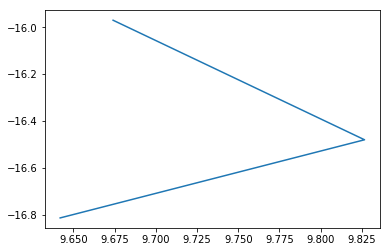

In [0]:
plot_lis2(train_rdplis[1])

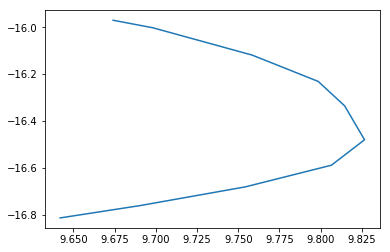

In [0]:
plot_lis2(train_merged[1])

In [0]:
dump_and_send(train_merged, "sym_rdp_longonly_train.pkl.gz")

Copying file://sym_rdp_longonly_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/30.3 MiB.                                     


In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
valid_merged = merge(valid_lis3, valid_rdplis, 207)

In [0]:
list3_to_max_stroke_len(valid_merged)

207

In [0]:
dump_and_send(valid_merged, "sym_rdp_longonly_valid.pkl.gz")

Copying file://sym_rdp_longonly_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  2.4 MiB/  2.4 MiB]                                                
Operation completed over 1 objects/2.4 MiB.                                      


In [0]:
dump_and_send(train_rdplis, "sym_rdplis_train.pkl.gz")

Copying file://sym_rdplis_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 19.5 MiB/ 19.5 MiB]                                                
Operation completed over 1 objects/19.5 MiB.                                     


In [0]:
def normalize_poslislis(poslislis):
    lislisarr = [np.array(one) for one in poslislis]
    maxpair = [one.max(0) for one in lislisarr]
    minpair = [one.min(0) for one in lislisarr]
    x_max = max(tup[0] for tup in maxpair)
    y_max = max(tup[1] for tup in maxpair)
    x_min = min(tup[0] for tup in minpair)
    y_min = min(tup[1] for tup in minpair)
    ratio = min(NORMALIZE_MAX/(0.0001+x_max-x_min), NORMALIZE_MAX/(0.0001+y_max-y_min))
    res = []
    for one in lislisarr:
      target = one.copy()
      target[:, 0] = (target[:, 0]-x_min)*ratio
      target[:, 1] = (target[:, 1]-y_min)*ratio
      res.append(target)
    return [one.astype(int) for one in res]


In [0]:
last_i=0

def list3_to_stroke_input_data(rdp_list3, maxstrokelen):
  global last_i
  stroke_input_data = np.zeros(
    (len(rdp_list3), maxstrokelen, INPUT_TYPE_DIM),
    dtype='int')
  for i, lislis in enumerate(rdp_list3):
    lislis = normalize_poslislis(lislis)
    last_i = i
    lislis = [np.array(poslis) for poslis in lislis]
    vec = poslislis2vec(lislis)
    stroke_input_data[i,0:vec.shape[0], : ] = vec
  return stroke_input_data

In [0]:
train_merge_stroke_input = list3_to_stroke_input_data(train_merged, 343)

In [0]:
train_merge_stroke_input.shape

(98289, 343, 3)

In [0]:
rdp_stroke_input.shape

(98289, 343, 3)

In [0]:
dump_and_send(train_merge_stroke_input, "sym_stroke_input_rdp_longonly_train.pkl.gz")

Copying file://sym_stroke_input_rdp_longonly_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/18.4 MiB.                                     


In [0]:
list3_to_max_stroke_len(valid_merged)

207

In [0]:
valid_merge_stroke_input = list3_to_stroke_input_data(valid_merged, 207)

In [0]:
valid_merge_stroke_input.shape

(10019, 207, 3)

In [0]:
dump_and_send(valid_merge_stroke_input, "sym_stroke_input_rdp_longonly_valid.pkl.gz")

Copying file://sym_stroke_input_rdp_longonly_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.4 MiB/  1.4 MiB]                                                
Operation completed over 1 objects/1.4 MiB.                                      


In [0]:
train2 = [dic for dic in train_sym_raw_list if len(dic['strokes'])!=0]

In [0]:
dump_and_send(train2, "crohme2019_subtask_train_dict_removeempty.pkl.gz")

Copying file://crohme2019_subtask_train_dict_removeempty.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/22.4 MiB.                                     


In [0]:
org_train_sym_raw_list = train_sym_raw_list
train_sym_raw_list = train2

In [0]:
valid_list3 = rawlist2lislislis(valid_sym_raw_list)

In [0]:
len(valid_list3)

10019

In [0]:
valid_rdplis = lislislis2rdplis(valid_list3)

In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
rdp_stroke_input_valid = rdp_list3_to_stroke_input_data_nonnormalize(valid_rdplis, 207)

In [0]:
dump_and_send(rdp_stroke_input_valid, "sym_stroke_input_rdp_valid_nonnormalize.pkl.gz")

Copying file://sym_stroke_input_rdp_valid_nonnormalize.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.0 MiB/  1.0 MiB]                                                
Operation completed over 1 objects/1.0 MiB.                                      


In [0]:
dump_and_send(valid_rdplis, "sym_rdplis_valid.pkl.gz")

Copying file://sym_rdplis_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      


### Write to TFRecord

In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [0]:
def convert_to_example(one_stroke_sample, one_label_sample):
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:, 0]),
      'input_y': _int64_feature(one_stroke_sample[:, 1]),
      'input_type': _int64_feature(one_stroke_sample[:, 2]),
      'label':_int64_feature([one_label_sample])}))
  return example

In [0]:
convert_to_example(train_merge_stroke_input[0], train_sym_labels[0])

In [0]:
def write_to_file(filename, stroke, labels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i in range(len(stroke)):
      example = convert_to_example(stroke[i], labels[i])
      writer.write(example.SerializeToString())


In [0]:
write_to_file("crohme2019_sym_rdp_longonly.tfrecord.gz", train_merge_stroke_input, train_sym_labels)

In [0]:
send_file("crohme2019_sym_rdp_longonly.tfrecord.gz")

Copying file://crohme2019_sym_rdp_longonly.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][ 15.4 MiB/ 15.4 MiB]                                                
Operation completed over 1 objects/15.4 MiB.                                     


In [0]:
write_to_file("crohme2019_sym_rdp_longonly_valid.tfrecord.gz", valid_merge_stroke_input, valid_sym_labels)

In [0]:
send_file("crohme2019_sym_rdp_longonly_valid.tfrecord.gz")

Copying file://crohme2019_sym_rdp_longonly_valid.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.3 MiB/  1.3 MiB]                                                
Operation completed over 1 objects/1.3 MiB.                                      


# pad symbol

Create dataset which pad to max stroke len.
The result data set shape is (batchsize, strokeindex, onesrokemax, INPUT_DIM).

We'll extract each stroke to one feature vector.

In [0]:
train_raw_list = get_and_load("crohme2019_fixed_train_tokenized.pkl.gz")
valid_raw_list = get_and_load("crohme2019_fixed_valid_tokenized.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_train_tokenized.pkl.gz...
- [1 files][ 20.5 MiB/ 20.5 MiB]                                                
Operation completed over 1 objects/20.5 MiB.                                     
Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_valid_tokenized.pkl.gz...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


### Check max stroke num

In [0]:
train_sym_raw_list[0:2]

[{'path': 'Train/isolatedTest2012/both4137.inkml',
  'strokes': ['12.3986 16.5841, 12.4026 16.5841, 12.3986 16.5841, 12.3946 16.5881, 12.3946 16.5921, 12.3866 16.5961, 12.3866 16.6041, 12.3866 16.6242, 12.3906 16.6483, 12.3785 16.6643, 12.3826 16.7004, 12.3665 16.7406, 12.3464 16.7767, 12.3224 16.7967, 12.3143 16.8328, 12.3103 16.8489, 12.2943 16.8609, 12.2742 16.8609, 12.2501 16.8609, 12.218 16.8529, 12.1859 16.8328, 12.1579 16.8007, 12.1418 16.7686, 12.1458 16.7205, 12.1458 16.6683, 12.1498 16.6362, 12.1498 16.6202, 12.1579 16.6202, 12.1659 16.6162, 12.1739 16.6202, 12.194 16.6282, 12.218 16.6443, 12.2622 16.6884, 12.3103 16.7245, 12.3705 16.7646, 12.4106 16.8048, 12.4468 16.8409, 12.4748 16.8569, 12.5029 16.873, 12.523 16.869'],
  'symbol': '\\alpha'},
 {'path': 'Train/isolatedTest2012/both7024.inkml',
  'strokes': ['9.67412 15.9702, 9.6982 16.0023, 9.75839 16.1186, 9.79851 16.231, 9.81456 16.3353, 9.8266 16.4797, 9.80654 16.5881, 9.75437 16.6804, 9.69017 16.7606, 9.64202 16.8128'],

In [0]:
max([len(one['strokes']) for one in train_sym_raw_list])

10

In [0]:
max([len(one['strokes']) for one in valid_sym_raw_list])

6

In [0]:
max([len(one[4]) for one in train_raw_list])

92

In [0]:
max([len(one[4]) for one in valid_raw_list])

115

Max stroke num is 115 in target dataset.
10 in symbol dataset.

### Check max stroke len

In [0]:
max([len(stroke2poslis(onestroke)) for one in train_sym_raw_list for onestroke in one['strokes']])

615

In [0]:
max([len(stroke2poslis(onestroke)) for one in valid_sym_raw_list for onestroke in one['strokes']])

1061

In [0]:
max([len(stroke2poslis(onestroke)) for one in train_raw_list for onestroke in one[4]])

615

In [0]:
max([len(stroke2poslis(onestroke)) for one in valid_raw_list for onestroke in one[4]])

1061

### Reduced max len investigation.

1061.
Seems too long for one stroke. We'll rdp for such case. before doing so, I want know the histogram.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

def plot_list(lis):
    plt.plot(listi(lis, 0),-listi(lis, 1))
    
def plot_lis2(lislis):
  for i in range(len(lislis)):
    plot_list(lislis[i])
    #plt.plot(listi(lislis[i], 0),-listi(lislis[i], 1))

(array([3.2765e+04, 4.3280e+04, 2.3053e+04, 1.4538e+04, 8.0170e+03,
        4.8910e+03, 2.9420e+03, 1.9940e+03, 1.1360e+03, 7.3700e+02,
        5.5700e+02, 3.5100e+02, 2.6500e+02, 1.7700e+02, 1.3000e+02,
        9.4000e+01, 8.6000e+01, 7.0000e+01, 5.6000e+01, 4.0000e+01,
        3.6000e+01, 2.2000e+01, 1.8000e+01, 1.5000e+01, 7.0000e+00,
        8.0000e+00, 1.3000e+01, 1.1000e+01, 1.0000e+01, 6.0000e+00,
        7.0000e+00, 9.0000e+00, 1.0000e+00, 5.0000e+00, 1.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  13.28,  25.56,  37.84,  50.12,  62.4 ,  74.68,  86.96,
         99.24, 111.52, 123.8 , 136.08, 148.36, 160.64, 172.92, 185.2 ,
        197.48, 209.76, 222.04, 234.32, 246.6 , 258.88, 271.16, 283.44,
        295.72, 308.  , 320.28, 332.56, 344.84, 357.12, 369.4 , 381.68,
        393.96, 406.24, 418.52

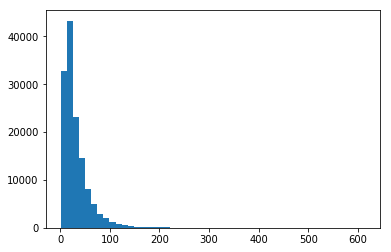

In [0]:
plt.hist([len(stroke2poslis(onestroke)) for one in train_raw_list for onestroke in one[4]], bins=50)

(array([6.092e+03, 2.873e+03, 1.404e+03, 7.280e+02, 5.210e+02, 4.230e+02,
        2.980e+02, 2.300e+02, 1.930e+02, 1.540e+02, 7.700e+01, 7.000e+01,
        4.300e+01, 3.100e+01, 3.400e+01, 3.000e+01, 2.000e+01, 2.200e+01,
        1.600e+01, 9.000e+00, 8.000e+00, 5.000e+00, 4.000e+00, 9.000e+00,
        3.000e+00, 2.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00, 1.000e+00, 5.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.0000e+00, 2.2200e+01, 4.3400e+01, 6.4600e+01, 8.5800e+01,
        1.0700e+02, 1.2820e+02, 1.4940e+02, 1.7060e+02, 1.9180e+02,
        2.1300e+02, 2.3420e+02, 2.5540e+02, 2.7660e+02, 2.9780e+02,
        3.1900e+02, 3.4020e+02, 3.6140e+02, 3.8260e+02, 4.0380e+02,
        4.2500e+02, 4.4620e+02, 4.6740e+02, 4.8860e+02, 5.0980e+02,
        5.3100e+02, 5.5220e+02, 5.73

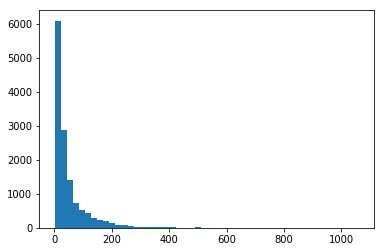

In [0]:
plt.hist([len(stroke2poslis(onestroke)) for one in valid_raw_list for onestroke in one[4]], bins=50)

In [0]:
sum([len(one[4]) for one in train_raw_list])

135364

In [0]:
sum([len(one[4]) for one in valid_raw_list])

13325

In [0]:
sum([1 for one in valid_raw_list for onestroke in one[4] if len(stroke2poslis(onestroke))<= 100])

11475

In [0]:
sum([1 for one in train_raw_list for onestroke in one[4] if len(stroke2poslis(onestroke))<= 100])

131595

In [0]:
sum([1 for one in train_raw_list for onestroke in one[4] if len(stroke2poslis(onestroke))<= 50])

113636

In [0]:
sum([1 for one in valid_raw_list for onestroke in one[4] if len(stroke2poslis(onestroke))<= 50])

9526

50 might be enough.
Confirm whether all stroke can reduced by rdp below this limit, and most of the result is good candidate for reduction.

In [38]:
!pip install rdp

  Created wheel for rdp: filename=rdp-0.8-cp36-none-any.whl size=4570 sha256=246a5f055f740cbdd75a21c9f59648acdd32fb552c28a491b09dcd70f0827261
  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
train_strokes_gt50 = [stroke2poslis(onestroke) for one in train_raw_list for onestroke in one[4] if len(stroke2poslis(onestroke))>= 50]

In [0]:
len(train_strokes_gt50)

22657

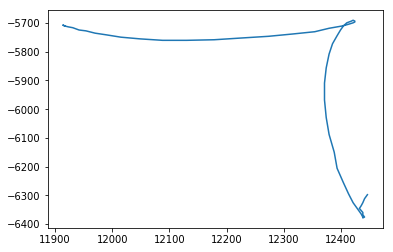

In [0]:
plot_list(train_strokes_gt50[0])

In [0]:
len(train_strokes_gt50[0])

54

In [0]:
len(rdp(train_strokes_gt50[0], 0.9))

39

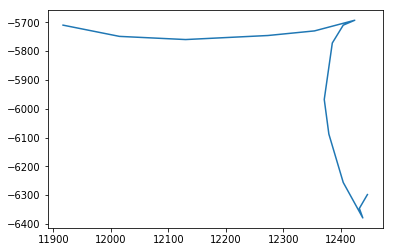

In [0]:
plot_list(rdp(train_strokes_gt50[0], 5.0))

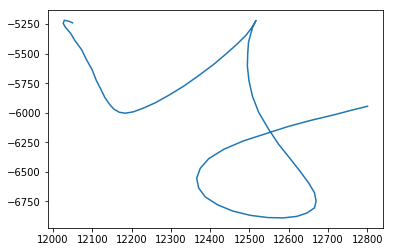

In [0]:
plot_list(train_strokes_gt50[1])

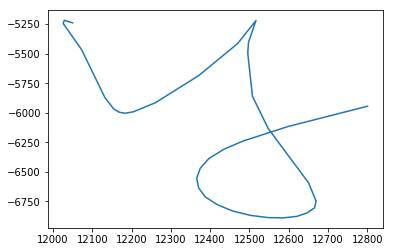

In [0]:
plot_list(rdp(train_strokes_gt50[1], 5.0))

In [0]:
len(train_strokes_gt50[2])

79

In [0]:
len(rdp(train_strokes_gt50[2], 5.0))

14

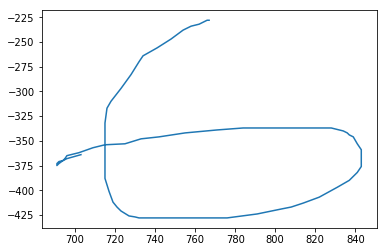

In [0]:
plot_list(train_strokes_gt50[2])

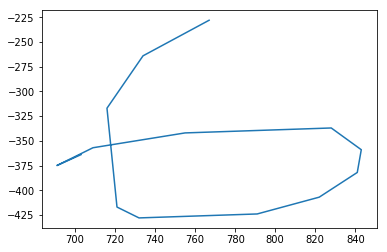

In [0]:
plot_list(rdp(train_strokes_gt50[2], 5.0))

In [0]:
train_strokes_gt50_rdp = [rdp(one,5.0) for one in train_strokes_gt50]

In [0]:
max(len(one) for one in train_strokes_gt50_rdp)

111

(array([1.3712e+04, 3.7720e+03, 3.6030e+03, 1.2240e+03, 2.4900e+02,
        7.1000e+01, 1.5000e+01, 7.0000e+00, 3.0000e+00, 1.0000e+00]),
 array([  2. ,  12.9,  23.8,  34.7,  45.6,  56.5,  67.4,  78.3,  89.2,
        100.1, 111. ]),
 <a list of 10 Patch objects>)

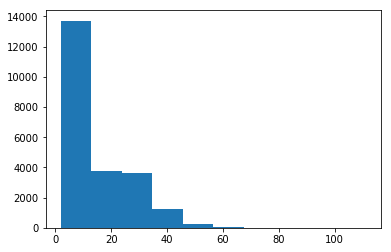

In [0]:
plt.hist([len(one) for one in train_strokes_gt50_rdp])

In [0]:
sum([1 for one in train_strokes_gt50_rdp if len(one)> 50])

184

In [0]:
rdp_gt50 = [one for one in train_strokes_gt50_rdp if len(one)> 50]

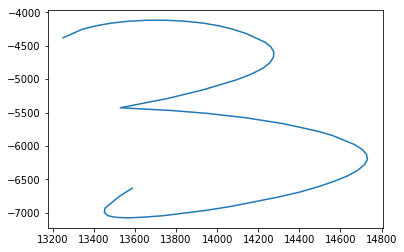

In [0]:
plot_list(rdp_gt50[0])

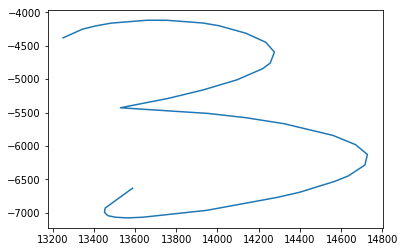

In [0]:
plot_list(rdp(rdp_gt50[0], 10.0))

In [0]:
len(rdp(rdp_gt50[0], 10.0))

36

In [0]:
len(rdp_gt50[0])

51

Some stroke need bery high epsilon while others is not.
We should apply multiple times for each stroke to reduce stroke size.

### Create pad stroke symbol data

In [0]:
!pip install rdp

  Created wheel for rdp: filename=rdp-0.8-cp36-none-any.whl size=4570 sha256=246a5f055f740cbdd75a21c9f59648acdd32fb552c28a491b09dcd70f0827261
  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
MAX_ONE_STROKE_LEN=50
MAX_STROKE_NUM=10

In [0]:
def reduce_stroke_till(poslis, target_max):
  epsilon = 0.5
  while len(poslis) > target_max:
    poslis = rdp(poslis, epsilon)
    epsilon *=2
  return poslis


In [0]:
def list3_to_reducedlist3(lis3, target_max):
  return [[reduce_stroke_till(poslis, target_max) for poslis in poslislis] for poslislis in tqdmn(lis3)]

In [0]:
def poslislis2nparray(poslislis):
  """To one nparray of shape (MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)
  padding is (0, 0, 0). normal input is (x, y, 1) 
  """
  lislis = [np.array(poslis) for poslis in poslislis]
  res = np.zeros((MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM))
  for i, one_stroke in enumerate(lislis):
    # onestoke (size, 2)
    stroke_len = one_stroke.shape[0]
    res[i, 0:stroke_len, 2] = INPUT_TYPE_POINT
    res[i, 0:stroke_len, :-1] = one_stroke
  return res

In [0]:
train_sym_list3 = rawlist2lislislis(train_sym_raw_list)

In [0]:
train_recuded_lis3 = list3_to_reducedlist3(train_sym_list3, MAX_ONE_STROKE_LEN)

In [0]:
dump_and_send(train_recuded_lis3, "sym_lis3_50_train.pkl.gz")

Copying file://sym_lis3_50_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/25.1 MiB.                                     


In [0]:
def list3_to_stroke_input_data(rdp_list3, maxstrokenum=MAX_STROKE_NUM):
  stroke_input_data = np.zeros(
    (len(rdp_list3), maxstrokenum, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM),
    dtype='int')
  for i, lislis in enumerate(rdp_list3):
    lislis = normalize_poslislis(lislis)
    onearr = poslislis2nparray(lislis)
    stroke_input_data[i,:, : :] = onearr
  return stroke_input_data

In [0]:
strokearr = list3_to_stroke_input_data(train_recuded_lis3)

In [0]:
strokearr.shape

(98289, 10, 50, 3)

In [0]:
dump_and_send(strokearr, "sym_stroke_input_50arr_train.pkl.gz")

Copying file://sym_stroke_input_50arr_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/15.6 MiB.                                     


In [0]:
train_strokearr = strokearr

In [0]:
train_strokearr[0, :, :, 0].reshape(-1).shape

(500,)

### Write to TFRecord

In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

In [0]:
def convert_to_example(one_stroke_sample, one_label_sample):
  """one_stroke_sample shape is (MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)"""
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:,:, 0].reshape(-1)),
      'input_y': _int64_feature(one_stroke_sample[:,:, 1].reshape(-1)),
      'input_type': _int64_feature(one_stroke_sample[:, :, 2].reshape(-1)),
      'label':_int64_feature([one_label_sample])}))
  return example

In [0]:
convert_to_example(train_strokearr[0], train_sym_labels[0])

In [0]:
def write_to_file(filename, stroke, labels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i in range(len(stroke)):
      example = convert_to_example(stroke[i], labels[i])
      writer.write(example.SerializeToString())


In [0]:
write_to_file("crohme2019_sym_50arr.tfrecord.gz", train_strokearr, train_sym_labels)

In [0]:
send_file("crohme2019_sym_50arr.tfrecord.gz")

Copying file://crohme2019_sym_50arr.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][ 13.5 MiB/ 13.5 MiB]                                                
Operation completed over 1 objects/13.5 MiB.                                     


In [0]:
valid_sym_list3 = rawlist2lislislis(valid_sym_raw_list)

In [0]:
valid_reduced_lis3 = list3_to_reducedlist3(valid_sym_list3, MAX_ONE_STROKE_LEN)

In [0]:
valid_strokearr = list3_to_stroke_input_data(valid_reduced_lis3)

In [0]:
write_to_file("crohme2019_sym_50arr_valid.tfrecord.gz", valid_strokearr, valid_sym_labels)

In [0]:
send_file("crohme2019_sym_50arr_valid.tfrecord.gz")

Copying file://crohme2019_sym_50arr_valid.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][  1.1 MiB/  1.1 MiB]                                                
Operation completed over 1 objects/1.1 MiB.                                      


# Expression with pad stroke 

Almost common logic as pad symbol.
This is not symbol preprocess, but this notebook is the most convinient place to implement.

In [0]:
train_raw_list = get_and_load("crohme2019_fixed_train_tokenized.pkl.gz")
valid_raw_list = get_and_load("crohme2019_fixed_valid_tokenized.pkl.gz")

Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_train_tokenized.pkl.gz...
/ [1 files][ 20.5 MiB/ 20.5 MiB]                                                
Operation completed over 1 objects/20.5 MiB.                                     
Copying gs://karino2-tegashiki/dataset/crohme2019_fixed_valid_tokenized.pkl.gz...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [0]:
MAX_STROKE_NUM=115
MAX_ONE_STROKE_LEN=50

In [0]:
def rawlist2lislislis_exp(raw_list):
  return [strokearr2poslislis(tup[4]) for tup in raw_list]

In [0]:
train_list3 = rawlist2lislislis_exp(train_raw_list)

In [0]:
train_reduced_lis3 = list3_to_reducedlist3(train_list3, MAX_ONE_STROKE_LEN)

In [0]:
dump_and_send(train_reduced_lis3, "exp_lis3_50_train.pkl.gz")

Copying file://exp_lis3_50_train.pkl.gz [Content-Type=application/octet-stream]...
-
Operation completed over 1 objects/23.0 MiB.                                     


In [0]:
train_strokearr = list3_to_stroke_input_data(train_reduced_lis3)

In [0]:
def rawlabels2df(rawlists):
  label_id_dict = {tup[0]: ",".join(map(lambda x:str(sym2id[x]), tup[3])) for tup in rawlists}
  return pd.DataFrame(label_id_dict.items(), columns=["file", "exp_ids"])

In [0]:
train_label_df = rawlabels2df(train_raw_list)

In [0]:
# +2 is bos, eos
MAX_TRAIN_TOKEN_LEN=88+2
MAX_VALID_TOKEN_LEN=206+2

In [0]:
# rename from traindf2decoder_data_tuple to labeldf2decoder_data_nparray
def labeldf2decoder_data_nparray(traindf, maxtklen=MAX_TRAIN_TOKEN_LEN):
  decoder_input_data = np.zeros(
      (len(traindf), maxtklen),
      dtype='uint8')
  
  decoder_sparse_target_data = np.zeros(
    (len(traindf), maxtklen),
    dtype='uint8')

  for i, row in traindf.iterrows():
    seq = [BEGIN_OF_SEQ] + [int(s) for s in row['exp_ids'].split(",")]
    decoder_input_data[i, 0:len(seq)] =seq
    decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]
  return decoder_input_data, decoder_sparse_target_data

In [0]:
train_decoder_input, train_decoder_target= labeldf2decoder_data_nparray(train_label_df, MAX_TRAIN_TOKEN_LEN)

### Write to TFRecord


In [0]:
# seems no int32
# https://www.tensorflow.org/tutorials/load_data/tf_records
def _int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def convert_to_example(one_stroke_sample, one_decoder_sample, one_label_sample):
  """one_stroke_sample shape is (MAX_STROKE_NUM, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)"""
  example = tf.train.Example(features=tf.train.Features(feature={
      'input_x': _int64_feature(one_stroke_sample[:,:, 0].reshape(-1)),
      'input_y': _int64_feature(one_stroke_sample[:,:, 1].reshape(-1)),
      'input_type': _int64_feature(one_stroke_sample[:, :, 2].reshape(-1)),
      'decoder_input':_int64_feature(one_decoder_sample),
      'decoder_labels':_int64_feature(one_label_sample)}))
  return example

def write_to_file(filename, stroke, decinput, sparselabels):
  with tf.python_io.TFRecordWriter(filename,
                                   tf.python_io.TFRecordOptions(tf.python_io.TFRecordCompressionType.GZIP)) as writer:
    for i in range(len(stroke)):
      example = convert_to_example(stroke[i], decinput[i], sparselabels[i])
      writer.write(example.SerializeToString())

In [0]:
write_to_file("crohme2019_padstroke.tfrecord.gz", train_strokearr, train_decoder_input, train_decoder_target)

In [0]:
send_file("crohme2019_padstroke.tfrecord.gz")

Copying file://crohme2019_padstroke.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][ 10.3 MiB/ 10.3 MiB]                                                
Operation completed over 1 objects/10.3 MiB.                                     


In [0]:
valid_list3 = rawlist2lislislis_exp(valid_raw_list)

In [0]:
valid_reduced_lis3 = list3_to_reducedlist3(valid_list3, MAX_ONE_STROKE_LEN)

In [0]:
valid_strokearr = list3_to_stroke_input_data(valid_reduced_lis3)

In [0]:
valid_label_df = rawlabels2df(valid_raw_list)

Filter out too large validation set data to match training set max token len (it make model training code much simpler)

In [0]:
MAX_TRAIN_TOKEN_LEN

90

In [0]:
# check validation set max
valid_label_df["exp_ids"].map(lambda x: len(x.split(","))).max()

206

In [0]:
filter_too_long = valid_label_df["exp_ids"].map(lambda x: len(x.split(","))<=MAX_TRAIN_TOKEN_LEN-2)

In [0]:
filter_too_long.shape

(958,)

In [0]:
valid_label_df.shape

(958, 2)

In [0]:
filtered_valid_label_df = valid_label_df[filter_too_long]

In [0]:
filtered_valid_label_df.shape

(957, 2)

In [0]:
filtered_valid_label_df["exp_ids"].map(lambda x: len(x.split(","))).max()

76

In [0]:
filtered_valid_label_df = filtered_valid_label_df.reset_index()

In [0]:
valid_decoder_input, valid_decoder_target= labeldf2decoder_data_nparray(filtered_valid_label_df, MAX_TRAIN_TOKEN_LEN)

In [0]:
valid_strokearr.shape

(958, 115, 50, 3)

In [0]:
filtered_valid_strokearr = valid_strokearr[filter_too_long, :, :, :]

In [0]:
tmp.shape

(957, 115, 50, 3)

In [0]:
write_to_file("crohme2019_padstroke_valid_sametokenlen.tfrecord.gz", filtered_valid_strokearr, valid_decoder_input, valid_decoder_target)

In [0]:
send_file("crohme2019_padstroke_valid_sametokenlen.tfrecord.gz")

Copying file://crohme2019_padstroke_valid_sametokenlen.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][843.3 KiB/843.3 KiB]                                                
Operation completed over 1 objects/843.3 KiB.                                    


### Write varlen TFRecord

In [0]:
def poslislis2nparray_varlen(poslislis):
  """To one nparray of shape (strokenum, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM)
  padding is (0, 0, 0). normal input is (x, y, 1) 
  """
  lislis = [np.array(poslis) for poslis in poslislis]
  strokenum = len(lislis)
  res = np.zeros((strokenum, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM))
  for i, one_stroke in enumerate(lislis):
    # onestoke (size, 2)
    stroke_len = one_stroke.shape[0]
    res[i, 0:stroke_len, 2] = INPUT_TYPE_POINT
    res[i, 0:stroke_len, :-1] = one_stroke
  return res

In [0]:
def list3_to_varlen_stroke_input_data(list3):
  res = []
  for i, lislis in enumerate(list3):
    lislis = normalize_poslislis(lislis)
    onearr = poslislis2nparray_varlen(lislis)
    res.append(onearr)
  return res

In [0]:
train_strokearr_varlen = list3_to_varlen_stroke_input_data(train_reduced_lis3)

In [0]:
len(train_strokearr_varlen)

9862

In [0]:
train_strokearr_varlen[0].shape

(6, 50, 3)

In [0]:
train_strokearr_varlen[1].shape

(22, 50, 3)

In [0]:
len(train_reduced_lis3[0])

6

In [0]:
# rename from traindf2decoder_data_tuple to labeldf2decoder_data_nparray
def labeldf2decoder_data_nparray_varlen(labeldf):
  decoder_input_data = []
  decoder_target_data = []

  for i, row in labeldf.iterrows():
    seq = [BEGIN_OF_SEQ] + [int(s) for s in row['exp_ids'].split(",")]
    one_input= np.zeros(len(seq), dtype='uint8')
    one_target= np.zeros(len(seq), dtype='uint8')
    one_input[:] = seq
    one_target[0:(len(seq)-1)] = one_input[1:len(seq)]
    decoder_input_data.append(one_input)
    decoder_target_data.append(one_target)
    # decoder_input_data[i, 0:len(seq)] =seq
   #  decoder_sparse_target_data[i, 0:(len(seq)-1)] =  decoder_input_data[i, 1:len(seq)]
  return decoder_input_data, decoder_target_data

In [0]:
train_decoder_input_varlen, train_decoder_target_varlen = labeldf2decoder_data_nparray_varlen(train_label_df)

In [0]:
train_strokearr_varlen_int = [one.astype(np.int) for one in train_strokearr_varlen]

In [0]:
write_to_file("crohme2019_padstroke_varlen.tfrecord.gz", train_strokearr_varlen_int, train_decoder_input_varlen, train_decoder_target_varlen)

In [0]:
send_file("crohme2019_padstroke_varlen.tfrecord.gz")

Copying file://crohme2019_padstroke_varlen.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][  9.6 MiB/  9.6 MiB]                                                
Operation completed over 1 objects/9.6 MiB.                                      


In [0]:
valid_strokearr_varlen = list3_to_varlen_stroke_input_data(valid_reduced_lis3)

In [0]:
valid_strokearr_varlen_int = [one.astype(np.int) for one in valid_strokearr_varlen]

In [0]:
valid_decoder_input_varlen, valid_decoder_target_varlen= labeldf2decoder_data_nparray_varlen(valid_label_df)

In [0]:
write_to_file("crohme2019_padstroke_varlen_valid.tfrecord.gz", valid_strokearr_varlen_int, valid_decoder_input_varlen, valid_decoder_target_varlen)

In [0]:
send_file("crohme2019_padstroke_varlen_valid.tfrecord.gz")

Copying file://crohme2019_padstroke_varlen_valid.tfrecord.gz [Content-Type=application/octet-stream]...
/ [1 files][787.6 KiB/787.6 KiB]                                                
Operation completed over 1 objects/787.6 KiB.                                    


In [0]:
len(train_decoder_input_varlen)

9862

(array([3.846e+03, 3.005e+03, 1.865e+03, 5.980e+02, 3.740e+02, 9.800e+01,
        3.600e+01, 2.200e+01, 1.000e+00, 1.700e+01]),
 array([ 2. , 10.7, 19.4, 28.1, 36.8, 45.5, 54.2, 62.9, 71.6, 80.3, 89. ]),
 <a list of 10 Patch objects>)

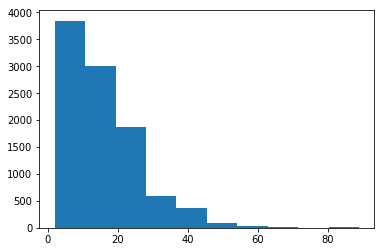

In [0]:
plt.hist([one.shape[0] for one in train_decoder_input_varlen])

In [0]:
len(train_decoder_input_varlen)

9862

In [0]:
len([one.shape[0] for one in train_decoder_input_varlen if one.shape[0] <= 10])

3846

In [0]:
len([one.shape[0] for one in train_decoder_input_varlen if one.shape[0] <= 20])

7150

In [0]:
train_is_lt10 = [one.shape[0]<=10 for one in train_decoder_input_varlen]

In [0]:
len(train_is_lt10)

9862

In [0]:
sum(train_is_lt10)

3846

In [0]:
train_strokearr_varlen_int[0].shape

(6, 50, 3)

In [0]:
train_strokearr_tklt10 = [tup[0] for tup in zip(train_strokearr_varlen_int, train_is_lt10) if tup[1]]

In [0]:
len(train_strokearr_tklt10)

3846

In [0]:
max([one.shape[0] for one in train_strokearr_tklt10])

35

In [0]:
valid_is_lt10 = [one.shape[0]<=10 for one in valid_decoder_input_varlen]

In [0]:
sum(valid_is_lt10)

381

In [0]:
valid_strokearr_tklt10 = [tup[0] for tup in zip(valid_strokearr_varlen_int, valid_is_lt10) if tup[1]]

In [0]:
max([one.shape[0] for one in valid_strokearr_tklt10])

20

In [0]:
train_decoder_input_varlen[0].shape

(8,)

In [0]:
train_decoder_input_varlen[1].shape

(42,)

In [0]:
train_decoder_input_varlen[1]

array([112,  83,  57,  29,  75,  57,  65, 110,  34, 109,  75,  57,  65,
       110, 110,  57, 102,  75,  57,  65, 110, 110,  89,  83,  57,  49,
        75,  57,  65, 110, 110,  57,  48,  75,  57,  65, 110, 110,  34,
        90,  93,   8], dtype=uint8)

In [0]:
train_decoder_target_varlen[1]

array([ 83,  57,  29,  75,  57,  65, 110,  34, 109,  75,  57,  65, 110,
       110,  57, 102,  75,  57,  65, 110, 110,  89,  83,  57,  49,  75,
        57,  65, 110, 110,  57,  48,  75,  57,  65, 110, 110,  34,  90,
        93,   8,   0], dtype=uint8)

In [0]:
lislis = [np.array(poslis) for poslis in train_reduced_lis3[0]]

In [0]:
lislis[0].shape

(29, 2)

In [0]:
lislis[1].shape

(7, 2)

In [0]:
max(tup.shape[0] for tup in lislis)

33

In [0]:
train_strokearr_varlen[0].astype(np.int)

array([[[   3,  453,    1],
        [   0,  446,    1],
        [  11,  449,    1],
        [  29,  453,    1],
        [  59,  442,    1],
        [ 115,  423,    1],
        [ 185,  382,    1],
        [ 271,  341,    1],
        [ 319,  297,    1],
        [ 353,  252,    1],
        [ 364,  200,    1],
        [ 364,  137,    1],
        [ 338,   63,    1],
        [ 304,   11,    1],
        [ 282,    0,    1],
        [ 275,    3,    1],
        [ 263,   14,    1],
        [ 249,   74,    1],
        [ 230,  133,    1],
        [ 234,  215,    1],
        [ 241,  301,    1],
        [ 256,  379,    1],
        [ 271,  483,    1],
        [ 278,  561,    1],
        [ 286,  620,    1],
        [ 286,  669,    1],
        [ 289,  691,    1],
        [ 293,  713,    1],
        [ 289,  713,    1],
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,    0],
        [   0,    0,

In [0]:
train_strokearr_varlen[0]

array([[[  3., 453.,   1.],
        [  0., 446.,   1.],
        [ 11., 449.,   1.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[211., 520.,   1.],
        [215., 516.,   1.],
        [219., 516.,   1.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[687., 490.,   1.],
        [665., 490.,   1.],
        [646., 490.,   1.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       ...,

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        ...,
        [  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,   0.,   0.]],

       [[  0.,   0.,   0.],
        [  0.,   0.,   0.],
        [  0.,  

# New data handling

### New dictionary upload

In [12]:
send_file("dictionary5.txt.gz")

Copying file://dictionary5.txt.gz [Content-Type=text/plain]...
/ [1 files][  599.0 B/  599.0 B]                                                
Operation completed over 1 objects/599.0 B.                                      


### New trining data code

In [0]:
import json

In [0]:
def load_strokes(prefix):
  files = !ls {prefix}*
  files2 = [f for line in files for f in  line.split()]
  strokelis3 = []
  for fname in files2:
    with open(fname) as f:
      strokelis3.extend(json.load(f))
  return strokelis3

In [0]:
def reshape2d(strokes):
  return [np.array(stroke).reshape(-1, 2) for stroke in strokes]

def plot_rstrokes(strokes):
  plot_lis2(reshape2d(strokes))

In [0]:
def list3_to_max_stroke_len(list3):
  return max([len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3])

In [0]:
def prefix_to_reducedlist3(prefix):
  raw_strokes = load_strokes(prefix)
  raw_vec = [reshape2d(stroke) for stroke in raw_strokes]
  
  train_num = len(raw_vec)*9//10
  train_raw_vec = raw_vec[0:train_num]
  valid_raw_vec = raw_vec[train_num:]
  
  train_reduced_lis3 = list3_to_reducedlist3(train_raw_vec, MAX_ONE_STROKE_LEN)
  valid_reduced_lis3 = list3_to_reducedlist3(valid_raw_vec, MAX_ONE_STROKE_LEN)
  
  return train_reduced_lis3, valid_reduced_lis3


In [0]:
def process_one(pat_name, prefix, train_dict, valid_dict):
  train, valid = prefix_to_reducedlist3(prefix)
  train_dict[pat_name] = train
  valid_dict[pat_name] = valid


### Handle New Pattern data


In [0]:
train_pat_dict = {}
valid_pat_dict = {}

In [0]:
def process_one_new(pat_name, prefix):
  process_one(pat_name, prefix, train_pat_dict, valid_pat_dict)

In [50]:
process_one_new("\\bm{b}", "bmb")
process_one_new("\\bm{c}", "bmc")
process_one_new("\\bm{p}", "bmp")
process_one_new("\\bm{q}", "bmq")
process_one_new("\\bm{r}", "bmr")
process_one_new("\\bm{x}", "bmx")
process_one_new("\\subseteq", "subseteq")


In [66]:
dump_and_send(train_pat_dict, "sym_lis3_50_bm_subseteq_train.pkl.gz")
dump_and_send(valid_pat_dict, "sym_lis3_50_bm_subseteq_valid.pkl.gz")

Copying file://sym_lis3_50_bm_subseteq_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][164.3 KiB/164.3 KiB]                                                
Operation completed over 1 objects/164.3 KiB.                                    
Copying file://sym_lis3_50_bm_subseteq_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 23.2 KiB/ 23.2 KiB]                                                
Operation completed over 1 objects/23.2 KiB.                                     


In [0]:
train_pat_dict.keys()

dict_keys(['\\bm{b}', '\\bm{c}', '\\bm{p}', '\\bm{q}', '\\bm{r}', '\\bm{x}', '\\subseteq'])

In [0]:
len(train_pat_dict['\\bm{b}']), len(train_pat_dict['\\bm{b}'][0])

(90, 2)

In [0]:
plot_lis2(train_pat_dict['\\bm{x}'][0])

In [0]:
plot_lis2(train_pat_dict['\\subseteq'][0])

In [59]:
len(valid_pat_dict['\\bm{b}'])

10

In [0]:
plot_lis2(valid_pat_dict['\\subseteq'][0])

### Handle added pattern

In [0]:
train_pat_added_dict = {}
valid_pat_added_dict = {}

In [0]:
def process_one_added(pat_name, prefix):
  process_one(pat_name, prefix, train_pat_added_dict, valid_pat_added_dict)

In [63]:
process_one_added("A", "A")
process_one_added("z", "z")


In [64]:
dump_and_send(train_pat_added_dict, "sym_lis3_50_Az_added_train.pkl.gz")
dump_and_send(valid_pat_added_dict, "sym_lis3_50_Az_added_valid.pkl.gz")

Copying file://sym_lis3_50_Az_added_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 48.2 KiB/ 48.2 KiB]                                                
Operation completed over 1 objects/48.2 KiB.                                     
Copying file://sym_lis3_50_Az_added_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  7.7 KiB/  7.7 KiB]                                                
Operation completed over 1 objects/7.7 KiB.                                      


In [0]:
plot_lis2(train_pat_added_dict['A'][0])

## MathbbR code

MathbbR is first version. So code is a little obsolete.

In [0]:
files = !ls mathbb*

In [0]:
files2 = [f for line in files for f in  line.split("\t")]

In [0]:
strokelis3 = []

In [0]:
for fname in files2:
  with open(fname) as f:
    strokelis3.extend(json.load(f))

In [0]:
len(strokelis3)

102

In [0]:
strokelis3_vec = [reshape2d(stroke) for stroke in strokelis3]

In [0]:
list3_to_max_stroke_len(strokelis3_vec)

62

In [0]:
max([len(one) for one in strokelis3_vec])

4

In [0]:
train_mathbbr = strokelis3_vec[0:80]
valid_mathbbr = strokelis3_vec[80:]

In [0]:
dump_and_send(train_mathbbr, "sym_mathbbr_train.pkl.gz")
dump_and_send(valid_mathbbr, "sym_mathbbr_valid.pkl.gz")

Copying file://sym_mathbbr_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 34.6 KiB/ 34.6 KiB]                                                
Operation completed over 1 objects/34.6 KiB.                                     
Copying file://sym_mathbbr_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 11.7 KiB/ 11.7 KiB]                                                
Operation completed over 1 objects/11.7 KiB.                                     


### reduce max len

Use "Create pad stroke symbol data" section

In [0]:
list3_to_max_stroke_len(train_mathbbr), list3_to_max_stroke_len(valid_mathbbr)

(62, 57)

In [0]:
# train_sym_list3 = rawlist2lislislis(train_sym_raw_list)

In [0]:
train_recuded_lis3 = list3_to_reducedlist3(train_mathbbr, MAX_ONE_STROKE_LEN)

In [0]:
dump_and_send(train_recuded_lis3, "sym_lis3_50_mathbbr_train.pkl.gz")

Copying file://sym_lis3_50_mathbbr_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 34.6 KiB/ 34.6 KiB]                                                
Operation completed over 1 objects/34.6 KiB.                                     


In [0]:
valid_recuded_lis3 = list3_to_reducedlist3(valid_mathbbr, MAX_ONE_STROKE_LEN)

In [0]:
dump_and_send(valid_recuded_lis3, "sym_lis3_50_mathbbr_valid.pkl.gz")

Copying file://sym_lis3_50_mathbbr_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 11.7 KiB/ 11.7 KiB]                                                
Operation completed over 1 objects/11.7 KiB.                                     


In [0]:
def list3_to_stroke_input_data(rdp_list3, maxstrokenum=MAX_STROKE_NUM):
  stroke_input_data = np.zeros(
    (len(rdp_list3), maxstrokenum, MAX_ONE_STROKE_LEN, INPUT_TYPE_DIM),
    dtype='int')
  for i, lislis in enumerate(rdp_list3):
    lislis = normalize_poslislis(lislis)
    onearr = poslislis2nparray(lislis)
    stroke_input_data[i,:, : :] = onearr
  return stroke_input_data

In [0]:
train_strokearr = list3_to_stroke_input_data(train_recuded_lis3)

In [0]:
train_strokearr.shape

(80, 10, 50, 3)

In [0]:
dump_and_send(train_strokearr, "sym_mathbbr_stroke_input_50arr_train.pkl.gz")

Copying file://sym_mathbbr_stroke_input_50arr_train.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][ 21.4 KiB/ 21.4 KiB]                                                
Operation completed over 1 objects/21.4 KiB.                                     


In [0]:
valid_strokearr = list3_to_stroke_input_data(valid_recuded_lis3)
valid_strokearr.shape

(22, 10, 50, 3)

In [0]:
dump_and_send(valid_strokearr, "sym_mathbbr_stroke_input_50arr_valid.pkl.gz")

Copying file://sym_mathbbr_stroke_input_50arr_valid.pkl.gz [Content-Type=application/octet-stream]...
/ [1 files][  6.1 KiB/  6.1 KiB]                                                
Operation completed over 1 objects/6.1 KiB.                                      


In [0]:
train_strokearr = strokearr

# Try and error

### normalize check

In [0]:
ratio

1.3262598590013361

In [0]:
target = [one.copy() for one in lislisarr]

In [0]:
normalize_poslislis(train_merged[6])

[array([[ 876,  420],
        [ 876,  385],
        [ 876,  385],
        [ 840,  420],
        [ 806,  492],
        [ 736,  561],
        [ 700,  665],
        [ 665,  771],
        [ 629,  842],
        [ 629,  948],
        [ 629, 1017],
        [ 665, 1087],
        [ 700, 1157],
        [ 736, 1193],
        [ 806, 1193],
        [ 876, 1157],
        [ 946, 1122],
        [1017, 1053],
        [1087,  982],
        [1122,  876],
        [1157,  771],
        [1157,  701],
        [1157,  596],
        [1122,  492],
        [1087,  420],
        [1017,  385],
        [ 946,  351],
        [ 876,  385],
        [ 806,  385],
        [ 770,  420],
        [ 700,  456],
        [ 665,  456]]), array([[ 175,  245],
        [ 175,  245],
        [ 175,  245],
        [ 140,  245],
        [ 104,  281],
        [ 104,  351],
        [  70,  420],
        [  34,  526],
        [   0,  665],
        [   0,  807],
        [   0,  948],
        [  34, 1053],
        [  70, 1157],
        [

In [0]:
res

[array([[ 876.6577668 ,  420.4243753 ],
        [ 876.6577668 ,  385.94161897],
        [ 876.6577668 ,  385.94161897],
        [ 840.84875061,  420.4243753 ],
        [ 806.36599427,  492.04240769],
        [ 736.07422175,  561.00792036],
        [ 700.26520555,  665.78244922],
        [ 665.78244922,  771.88323794],
        [ 629.97343303,  842.17501047],
        [ 629.97343303,  948.27579919],
        [ 629.97343303, 1017.24131185],
        [ 665.78244922, 1087.53308438],
        [ 700.26520555, 1157.82485691],
        [ 736.07422175, 1193.6338731 ],
        [ 806.36599427, 1193.6338731 ],
        [ 876.6577668 , 1157.82485691],
        [ 946.94953933, 1122.01584072],
        [1017.24131185, 1053.05032805],
        [1087.53308438,  982.75855552],
        [1122.01584072,  876.6577668 ],
        [1157.82485691,  771.88323794],
        [1157.82485691,  701.59146541],
        [1157.82485691,  596.81693655],
        [1122.01584072,  492.04240769],
        [1087.53308438,  420.4243753 ],


In [0]:
x_min, x_max, y_min, y_max

(9102.0, 10610.0, 3704.0, 4735.0)

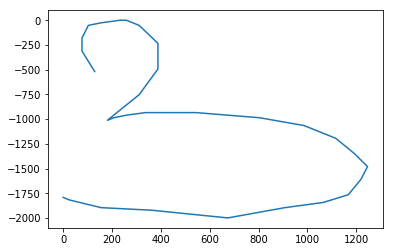

In [0]:
plot_lis2(normalize_poslislis(train_merged[4]))

In [0]:
min(tup[0] for tup in minpair)

9102.0

In [0]:
target = train_merged[6].copy()

In [0]:
one_lis2arr = [np.array(one) for one in one_lis2]

In [0]:
x_max, y_max = one_lis2arr[0].max(0)

In [0]:
x_min, y_min  = one_lis2arr[0].min(0)

In [0]:
x_aligned = one_lis2arr[0][:, 0]-x_min

In [0]:
x_aligned

array([0.2568, 0.2608, 0.2568, 0.2528, 0.2528, 0.2448, 0.2448, 0.2448,
       0.2488, 0.2367, 0.2408, 0.2247, 0.2046, 0.1806, 0.1725, 0.1685,
       0.1525, 0.1324, 0.1083, 0.0762, 0.0441, 0.0161, 0.    , 0.004 ,
       0.004 , 0.008 , 0.008 , 0.0161, 0.0241, 0.0321, 0.0522, 0.0762,
       0.1204, 0.1685, 0.2287, 0.2688, 0.305 , 0.333 , 0.3611, 0.3812])

In [0]:
x_max, y_max

(12.523, 16.873)

In [0]:
one_lis2arr[0].max((0, 1))

16.873

In [0]:
res = normalize_poslislis(train_merged[0])

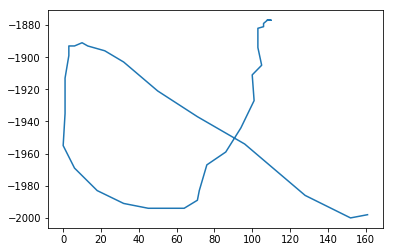

In [0]:
plot_lis2(res)

### Encoder input setup

In [0]:
rdp_stroke_input = get_and_load("stroke_sym_input_rdp_train_nonnormalize.pkl.gz")
rdp_stroke_input_valid = get_and_load("stroke_sym_input_rdp_valid_nonnormalize.pkl.gz")

Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_train.pkl.gz...
/ [1 files][ 10.6 MiB/ 10.6 MiB]                                                
Operation completed over 1 objects/10.6 MiB.                                     
Copying gs://karino2-tegashiki/dataset/stroke_input_rdp_valid.pkl.gz...
/ [1 files][977.8 KiB/977.8 KiB]                                                
Operation completed over 1 objects/977.8 KiB.                                    


In [0]:
poslislis = strokearr2poslislis(train_sym_raw_list[6]["strokes"])

In [0]:
MAX_TRAIN_LEN

90

In [0]:
MAX_STROKE_SEQ_LEN

2773

In [0]:
tf.feature_column.numeric_column(key="input_stroke", shape=(MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM))

NumericColumn(key='input_stroke', shape=(2773, 3), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
tf.feature_column.numeric_column(key="input_decoder", shape=(MAX_TRAIN_LEN,))

NumericColumn(key='input_decoder', shape=(90,), default_value=None, dtype=tf.float32, normalizer_fn=None)

In [0]:
decoder_input_data.shape

NameError: ignored

In [0]:
3*2773

8319

In [0]:
stroke_input.shape

(8190, 2773, 3)

### Check MAX

In [0]:
train_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

88

In [0]:
# check validation set max
valid_labels = rawlabels2df(valid_raw_list)
valid_labels["exp_ids"].map(lambda x: len(x.split(","))).max()

206

In [0]:
sum(tup.split(","))

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
def calc_stroke_len(strokearr):
  return len(strokearr)+ sum(len(stroke.split(",")) for stroke in strokearr)

In [0]:
#MAX_STROKE_SEQ_LEN
max(calc_stroke_len(tup[4]) for tup in train_raw_list)

3193

In [0]:
max(calc_stroke_len(tup[4]) for tup in valid_raw_list)

6620

In [0]:
!pip install rdp

In [0]:
from rdp import rdp

In [0]:
def calc_stroke_len_with_rdp(strokearr, epsilon=0.05):
  poslislis = strokearr2poslislis(strokearr)
  return len(poslislis)+sum(len(rdp(one, epsilon=epsilon)) for one in poslislis)

In [0]:
max(calc_stroke_len_with_rdp(tup[4]) for tup in train_raw_list)

In [0]:
%%time

max(calc_stroke_len_with_rdp(tup[4]) for tup in valid_raw_list)

In [0]:
len(train_labels)

NameError: ignored

In [0]:
stroke_input.shape

(8190, 2773, 3)

In [0]:
#  # (batch, times, 3)
# input_from_encoder_t = tf.placeholder(tf.float32, shape=[None, MAX_STROKE_SEQ_LEN, INPUT_TYPE_DIM])


Instructions for updating:
Colocations handled automatically by placer.


### rdp trial

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
def listi(lis, pos):
  return np.array([tup[pos] for tup in lis])

In [0]:
def plot_lis2(lislis):
  for i in range(len(lislis)):
    plt.plot(listi(lislis[i], 0),-listi(lislis[i], 1))

In [0]:
!pip install rdp

  Stored in directory: /root/.cache/pip/wheels/76/e4/02/c738593caece49c63180d093651bec3cd3b02ea3248f076f07
Successfully built rdp


In [0]:
from rdp import rdp

In [0]:
stroke_input.shape

(9862, 3193, 3)

In [0]:
train_raw_list[0][4]

['10.7816 21.4071, 10.7776 21.3991, 10.7896 21.4031, 10.8097 21.4071, 10.8418 21.3951, 10.9019 21.375, 10.9782 21.3309, 11.0705 21.2867, 11.1226 21.2386, 11.1587 21.1904, 11.1708 21.1342, 11.1708 21.066, 11.1427 20.9858, 11.1066 20.9296, 11.0825 20.9176, 11.0745 20.9216, 11.0624 20.9336, 11.0464 20.9978, 11.0263 21.062, 11.0303 21.1503, 11.0384 21.2426, 11.0544 21.3268, 11.0705 21.4392, 11.0785 21.5235, 11.0865 21.5877, 11.0865 21.6398, 11.0905 21.6639, 11.0945 21.688, 11.0905 21.688',
 '11.0063 21.4793, 11.0103 21.4753, 11.0143 21.4753, 11.0344 21.4713, 11.0865 21.4673, 11.1467 21.4633, 11.2591 21.4472',
 '11.5199 21.4472, 11.4958 21.4472, 11.4757 21.4472, 11.4557 21.4352, 11.4476 21.4352, 11.4396 21.4151, 11.4436 21.3991, 11.4517 21.387, 11.4677 21.367, 11.4958 21.363, 11.5159 21.375, 11.5439 21.383, 11.552 21.4071, 11.552 21.4272, 11.5319 21.4352, 11.4918 21.4753, 11.4476 21.5074, 11.4196 21.5475, 11.4196 21.5676, 11.4236 21.5756, 11.4436 21.5877, 11.5159 21.6077, 11.6282 21.6157',


In [0]:
poslislis = strokearr2poslislis(one_stroke_list)

In [0]:
len(poslislis)

6

In [0]:
len(poslislis[0])

29

In [0]:
rdp(poslislis[0], epsilon=1.0)

[[10.7816, 21.4071], [11.0905, 21.688]]

In [0]:
rdp(poslislis[1], epsilon=1.0)

[[11.0063, 21.4793], [11.2591, 21.4472]]

In [0]:
poslislis[1]

[(11.0063, 21.4793),
 (11.0103, 21.4753),
 (11.0143, 21.4753),
 (11.0344, 21.4713),
 (11.0865, 21.4673),
 (11.1467, 21.4633),
 (11.2591, 21.4472)]

In [0]:
rdp(poslislis[2], epsilon=0.5)

[[11.5199, 21.4472], [11.6282, 21.6157]]

In [0]:
poslislis[2]

[(11.5199, 21.4472),
 (11.4958, 21.4472),
 (11.4757, 21.4472),
 (11.4557, 21.4352),
 (11.4476, 21.4352),
 (11.4396, 21.4151),
 (11.4436, 21.3991),
 (11.4517, 21.387),
 (11.4677, 21.367),
 (11.4958, 21.363),
 (11.5159, 21.375),
 (11.5439, 21.383),
 (11.552, 21.4071),
 (11.552, 21.4272),
 (11.5319, 21.4352),
 (11.4918, 21.4753),
 (11.4476, 21.5074),
 (11.4196, 21.5475),
 (11.4196, 21.5676),
 (11.4236, 21.5756),
 (11.4436, 21.5877),
 (11.5159, 21.6077),
 (11.6282, 21.6157)]

In [0]:
plt.plot(listi(poslislis[0], 0),-listi(poslislis[0], 1))
plt.plot(listi(poslislis[1], 0),-listi(poslislis[1], 1))
plt.plot(listi(poslislis[2], 0),-listi(poslislis[2], 1))
plt.plot(listi(poslislis[3], 0),-listi(poslislis[3], 1))
plt.plot(listi(poslislis[4], 0),-listi(poslislis[4], 1))
plt.plot(listi(poslislis[5], 0),-listi(poslislis[5], 1))

In [0]:
rdplislis = [rdp(lis, epsilon=0.5) for lis in poslislis]

In [0]:
rdplislis = train_rdplis[1]

In [0]:
train_sym_raw_list[1]['symbol']

')'

### data check

some data seems too simplify.
But some data seems too noisy.

I decide rdp reduction only for long stroke.
Long is defined by max length of all rdp-ed strokes.

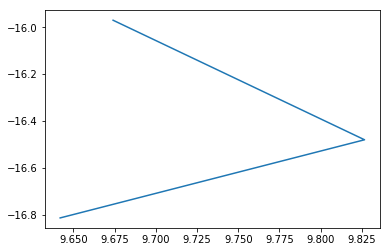

In [0]:
plot_lis2(train_rdplis[1])

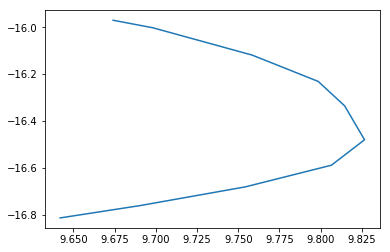

In [0]:
plot_lis2(lislislis[1])

In [0]:
lislislis = rawlist2lislislis(train_sym_raw_list)

In [0]:
train_lis3 = lislislis

In [0]:
valid_lis3 = rawlist2lislislis(valid_sym_raw_list)

In [0]:
len(lislislis)

98290

In [0]:
len(poslislis[0])

32

In [0]:
len(lislislis[6][0])

32

In [0]:
train_rdplis = lislislis2rdplis(lislislis)

In [0]:
list3_to_max_stroke_len(valid_lis3)

1621

In [0]:
def list3_to_indexlen(list3):
  return [(i, len(poslislis)+sum(len(one) for one in poslislis)) for i, poslislis in enumerate(list3)]

In [0]:
val_index_len_pair = [(i, len(poslislis)+sum(len(one) for one in poslislis)) for i, poslislis in enumerate(valid_lis3)]

In [0]:
len([tup for tup in val_index_len_pair if tup[1] > 616])

28

In [0]:
[tup for tup in val_index_len_pair if tup[1] > 616]

[(689, 713),
 (1197, 718),
 (2473, 768),
 (2691, 787),
 (3024, 877),
 (3103, 677),
 (3347, 675),
 (4178, 758),
 (4478, 705),
 (4614, 861),
 (5010, 942),
 (5899, 627),
 (5940, 626),
 (5944, 710),
 (6353, 694),
 (6913, 1621),
 (7036, 804),
 (7050, 648),
 (7519, 629),
 (7614, 678),
 (7682, 656),
 (8245, 679),
 (8599, 720),
 (8983, 721),
 (9364, 652),
 (9544, 800),
 (9668, 1062),
 (9898, 634)]

In [0]:
valid_sym_raw_list[9668]

{'path': 'valid/isolated_testSymbols2014/testSymbols/iso166.inkml',
 'strokes': ['208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 208 62, 207 61, 207 61, 207 61, 207 61, 207 61, 207 61, 205 62, 205 62, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 202 63, 201 63, 201 63, 201 63, 201 63, 200 64, 200 64, 200 64, 199 65, 199 65, 199 65, 198 66, 198 66, 198 66, 198 66, 196 67, 196 67, 196 67, 196 67, 196 68, 196 68, 196 68, 193 70, 193 70, 193 70, 192 70, 192 70, 192 70, 191 72, 191 72, 191 72, 191 72, 191 72, 190 73, 190 73, 188 74, 188 74, 188 75, 188 75, 188 75, 188 75, 188 75, 188 75, 188 75, 187 77, 187 77, 187 77, 187 77, 187 77, 186 79, 186 79, 186 79, 184 80, 184 80, 184 80, 184 80, 184 80, 184 82, 184 82, 184 82, 183 84, 183 84, 183 84, 183 84, 183 84, 183 84, 183 84, 183 85

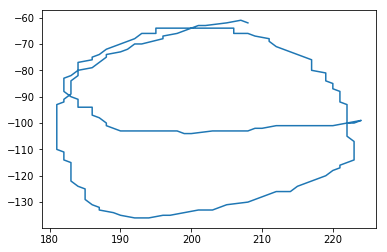

In [0]:
plot_lis2(valid_lis3[9668])

In [0]:
valid_rdplis = get_and_load("sym_rdplis_valid.pkl.gz")

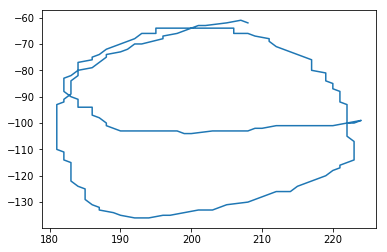

In [0]:
plot_lis2(valid_rdplis[9668])

In [0]:
sum(len(stroke) for stroke in valid_rdplis[9668])

104

In [0]:
def lis2_len(lislis):
  return len(lislis)+sum(len(one) for one in lislis)


In [0]:
lis2_len(valid_lis3[9668])

1062

In [0]:
sum(len(stroke) for stroke in valid_lis3[9668])

1061

In [0]:
train_indlen = list3_to_indexlen(train_lis3)

In [0]:
[tup for tup in train_indlen if tup[1] > 500]

[(48681, 501),
 (49821, 519),
 (52936, 531),
 (53457, 601),
 (77407, 616),
 (80168, 597),
 (94532, 513)]

In [0]:
MAX_STROKE_SEQ_LEN=343

1948

In [0]:
list3_to_max_stroke_len(lislislis)

616

343

In [0]:
list3_to_max_stroke_len(valid_rdplis)

207

In [0]:
len(train_rdplis), len(train_lis3)

(98290, 98289)

In [0]:
rdp_stroke_input.shape

(9862, 1948, 3)

In [0]:
def list3_to_stroke_len(list3):
  return [len(poslislis)+sum(len(one) for one in poslislis) for poslislis in list3]


In [0]:
train_lens = list3_to_stroke_len(train_rdplis)

In [0]:
len(train_lens)

9862

(array([1.383e+03, 1.258e+03, 9.100e+02, 7.090e+02, 6.070e+02, 5.320e+02,
        5.270e+02, 4.430e+02, 4.320e+02, 3.800e+02, 3.860e+02, 3.670e+02,
        3.130e+02, 2.470e+02, 2.330e+02, 2.150e+02, 1.830e+02, 1.240e+02,
        1.060e+02, 8.600e+01, 8.400e+01, 8.200e+01, 5.000e+01, 3.900e+01,
        4.300e+01, 2.300e+01, 2.100e+01, 1.500e+01, 5.000e+00, 1.400e+01,
        1.000e+01, 4.000e+00, 6.000e+00, 6.000e+00, 2.000e+00, 1.000e+00,
        6.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00]),
 array([   9.  ,   47.78,   86.56,  125.34,  164.12,  202.9 ,  241.68,
         280.46,  319.24,  358.02,  396.8 ,  435.58,  474.36,  513.14,
         551.92,  590.7 ,  629.48,  668.26,  707.04,  745.82,  784.6 ,
         823.38,  862.16,  900.94,  939.72,  978.5 , 1017.28, 1056.06,
        1094.84, 1133.62, 1172.4 , 1211.18, 1249.96, 1288.74, 1327.52,
        1366.3 , 1405

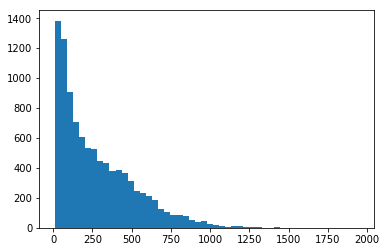

In [0]:
plt.hist(train_lens, bins=50)

In [0]:
(np.array(train_lens)<500).sum()

8131

In [0]:
(np.array(train_lens)>=500).sum()

1731

### Misc